In [381]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd

In [382]:
def nndsvd_initialization(A, rank):

    u, s, v = np.linalg.svd(A, full_matrices=False)
    v = v.T
    w = np.zeros((A.shape[0], rank))
    h = np.zeros((rank, A.shape[1]))

    w[:, 0] = np.sqrt(s[0]) * np.abs(u[:, 0])
    h[0, :] = np.sqrt(s[0]) * np.abs(v[:, 0].T)

    for i in range(1, rank):
        ui = u[:, i]
        vi = v[:, i]
        ui_pos = (ui >= 0) * ui
        ui_neg = (ui < 0) * -ui
        vi_pos = (vi >= 0) * vi
        vi_neg = (vi < 0) * -vi

        ui_pos_norm = np.linalg.norm(ui_pos, 2)
        ui_neg_norm = np.linalg.norm(ui_neg, 2)
        vi_pos_norm = np.linalg.norm(vi_pos, 2)
        vi_neg_norm = np.linalg.norm(vi_neg, 2)

        norm_pos = ui_pos_norm * vi_pos_norm
        norm_neg = ui_neg_norm * vi_neg_norm

        if norm_pos >= norm_neg:
            w[:, i] = np.sqrt(s[i] * norm_pos) / ui_pos_norm * ui_pos
            h[i, :] = np.sqrt(s[i] * norm_pos) / vi_pos_norm * vi_pos.T
        else:
            w[:, i] = np.sqrt(s[i] * norm_neg) / ui_neg_norm * ui_neg
            h[i, :] = np.sqrt(s[i] * norm_neg) / vi_neg_norm * vi_neg.T

    return w, h



def divergence(V,W,H):
    return np.sum(V * np.log((V) / (W @ H)) - V + W @ H)


def NMF(V, S, MAXITER, threshold = 1e-12): 

    counter = 0
    cost_function = []
    beta_divergence = 1
    
    W, H = nndsvd_initialization(V, S)

    while beta_divergence >= threshold and counter <= MAXITER:
        
        H *= (W.T @ V) / (W.T @ (W @ H) + 10e-10)
        H[H < 0] = 0
        W *= (V @ H.T) / ((W @ H) @ H.T + 10e-10)
        W[W < 0] = 0
        
        beta_divergence =  divergence(V, W, H)
        cost_function.append(beta_divergence)
        counter += 1

    return W, H


In [383]:
FRAME1 = 1024
HOP = 512

In [384]:
audio_file = "../data/sound1_mix.mp3"
y, sr = librosa.load(audio_file)
D = librosa.stft(y, n_fft=FRAME1, hop_length=HOP)
magnitude = np.abs(D) 
ipd.Audio(y, rate = sr)

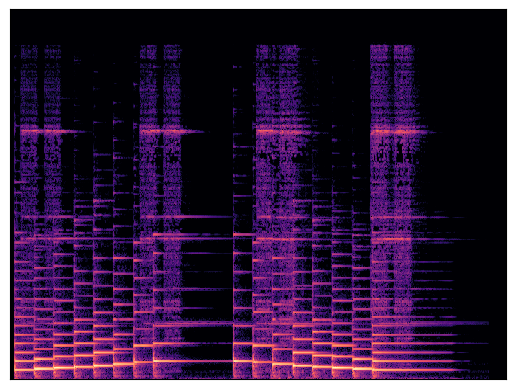

In [385]:
librosa.display.specshow(librosa.amplitude_to_db(magnitude), sr=sr, n_fft=FRAME1, hop_length=HOP)

In [386]:
channels = 128
W, H = NMF(magnitude, channels, 10000)
#from sklearn.decomposition import NMF
# model = NMF(n_components = 2, init='nndsvd', random_state=0, max_iter= 100000000000000000000000, l1_ratio=0.000000000001)
# W = model.fit_transform(magnitude)
# H = model.components_

C:\Users\Admin\AppData\Local\Temp\ipykernel_12460\3689226807.py:39: RuntimeWarning: invalid value encountered in divide
  return np.sum(V * np.log((V) / (W @ H)) - V + W @ H)


In [387]:
# dims = np.shape(magnitude)
# rows = dims[0]
# cols = dims[1]
# f, axs = plt.subplots(channels, 2, figsize=(12,12))
# axs[0,0].set_title = "W"
# axs[0,1].set_title = "H"
# for row in range(channels):
#     axs[row,0].plot(np.linspace(0, 11025,rows),W[:,row])
#     axs[row,1].plot(np.linspace(0, 71,cols),H[row])
    

In [388]:
sound_lst = []
for i in range(2):
    sound_stft_A = np.angle(D)
    filters = list(range(channels))
    filters = [x % 2 == i for x in filters]
    filtered = W[:,filters]@H[filters,:]
    reconst = filtered * np.exp(1j*sound_stft_A)
    new_sound = librosa.istft(reconst, n_fft=FRAME1, hop_length=HOP)
    sound_lst.append(new_sound)

In [389]:
for sound in sound_lst:
    display(ipd.Audio(sound, rate=sr))

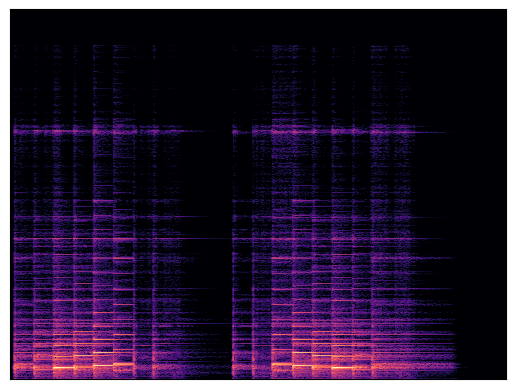

In [390]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(sound_lst[0]))), sr=sr, n_fft=FRAME1, hop_length=HOP)

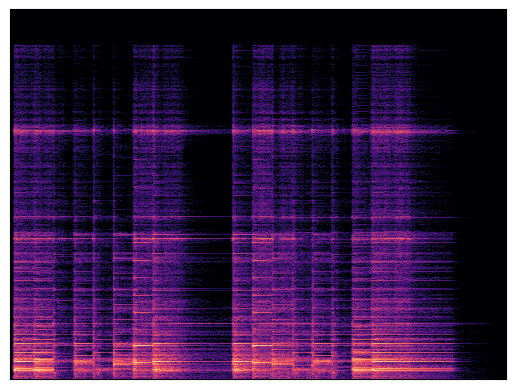

In [391]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(sound_lst[1]))), sr=sr, n_fft=FRAME1, hop_length=HOP)

In [392]:
#from sklearn.decomposition import NMF


def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err



def data_getter(channels = 16):
    "Gets data"
    iters = list(range(100, 1100, 100))
    mse_res = []
    for iter in iters:
        audio_file = "../data/sound1_mix.mp3"
        y, _ = librosa.load(audio_file)
        D = librosa.stft(y, n_fft=FRAME1, hop_length=HOP)
        magnitude = np.abs(D) 
        W, H = NMF(magnitude, channels, MAXITER=iter)
        # model = NMF(n_components = channels, init='nndsvd', random_state=0, max_iter=iter, l1_ratio=0.000000000001)
        # W = model.fit_transform(magnitude)
        # H = model.components_
        sound_lst = []
        for i in range(2):
            sound_stft_A = np.angle(D)
            filters = list(range(channels))
            filters = [x % 2 == i for x in filters]
            filtered = W[:,filters]@H[filters,:]
            reconst = filtered * np.exp(1j*sound_stft_A)
            new_sound = librosa.istft(reconst, n_fft=FRAME1, hop_length=HOP)
            sound_lst.append(new_sound)
        new_sound = sound_lst[0]
        new_sound = new_sound[:265217]
        new_stft = librosa.stft(new_sound, n_fft=FRAME1, hop_length=HOP)
        audio_file = "../data/sound2.wav"
        x, _ = librosa.load(audio_file)
        MTX = librosa.stft(x, n_fft=FRAME1, hop_length=HOP)
        res = mse(MTX, new_stft)
        mse_res.append(res)
    return iters, mse_res

C:\Users\Admin\AppData\Local\Temp\ipykernel_12460\3689226807.py:39: RuntimeWarning: invalid value encountered in divide
  return np.sum(V * np.log((V) / (W @ H)) - V + W @ H)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12460\2060118004.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)


[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[0.19132063235025915, 0.19132063235025915, 0.19132063235025915, 0.19132063235025915, 0.19132063235025915, 0.19132063235025915, 0.19132063235025915, 0.19132063235025915, 0.19132063235025915, 0.19132063235025915]


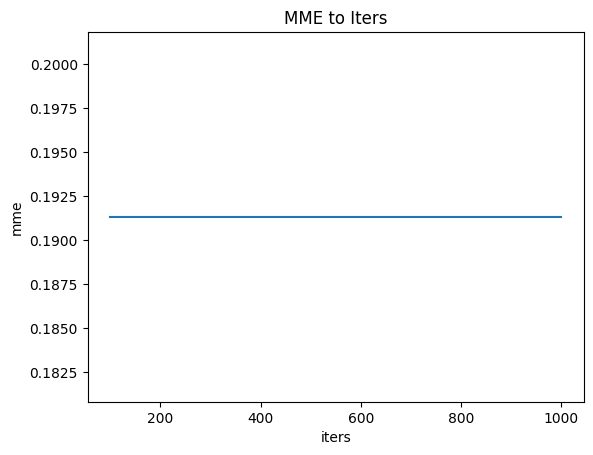

In [393]:
iters, mse_res = data_getter()
print(iters)
print(mse_res)
plt.plot(iters, mse_res)

# Adding labels and title
plt.xlabel('iters')
plt.ylabel('mme')
plt.title('MME to Iters')

# Display the graph
plt.show()